In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__, keras.__version__)

2.3.1 2.4.0


### Downloading Fashion mnist data

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print(X_train_full.shape, X_test.shape)

4423680/4422102 [==============================] - 1s 0us/step
(60000, 28, 28) (10000, 28, 28)


### Create Validation Data Set

Also in addition to that do a very basic scaling (ie. dividing data by 255)

In [3]:
X_train, X_valid  = X_train_full[5000:] / 255.0, X_train_full[:5000] / 255.0
y_train, y_valid  = y_train_full[5000:], y_train_full[:5000]

print(X_train.shape, X_valid.shape)

(55000, 28, 28) (5000, 28, 28)


In [4]:
class_names = ["T-shirt/pop", "Trouser", "Pullover", "Dresss", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## Building Keras Model

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation = "relu"))
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dense(10, activation = "softmax"))

In [6]:
## Same Effect as:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation = "relu"),
        keras.layers.Dense(100, activation = "relu"),
        keras.layers.Dense(10, activation = "softmax")
])

### Print Model Summary
The model summary can be easily viewed by calling **summary()** function. The number of params in Dense Layer is:

- Flatten is basically doing np.reshape(-1, 28*28). Changing the dimention of the input observation to 2 dimensions (square to a line)
- Dense is a layer of fully connected neurons
- The final layer consists of 10 class as output. Placing a softmax at the end. (using argmax to find the predicted class.

#Neurons from previous layer times #Neurons of the current layer + #Neurons of the current layer (biases)

Additionally each layer can be accessed via **layers** property.

Weights can be accessed via **get_weights()** function for each of the layer



In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [8]:
weights, bias = model.layers[1].get_weights()
print(weights.shape, bias.shape)

(784, 300) (300,)


### Compiling Model

Before model can be trained, it needs to be compiled. The key arguments are:

- loss functions: for multiclass use sparse_categorical_crossentropy, for binar class, we can use catagorical_crossentroy. (https://keras.io/loss for more details (equivalent to tf.keras.loss.sparse_categorical_crossentropy)
- optimizer: for example use SGD, Adam (https://keras.io/optimizers
- merics: can specify "accuracy" which is equivalent to tf.keras.metrics.sparse_categorical_accuracy

Also note the dense layers are automatically initialised with random weight (0 bias), there maybe different initialisation should there be problem with converging (due to vanishing gradients) https://keras.io/initializers

In [9]:
# both statements are the same

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=tf.keras.optimizers.SGD(lr = 0.3), 
#              loss = tf.keras.losses.sparse_categorical_crossentropy, 
#              metrics = [tf.keras.metrics.sparse_top_k_categorical_accuracy])

### Training

**Validation**
Instead passing a validation dataset, we can also pass in a **validation_split** argument. (For example, validation_split = 0.1 tells Keras to use at least 10% of data for validation)

**Class Weight**
If the classes are skewed, we can use class_weight argument which will give larger weight to underrepresented classes and a lower weight to overrepresented classes. These weigts are used to caculate loss. 

Can use also sample_weight for per-instance weights. This could be useful if some instances were labeled by *experts* and other classes are labeled via *crowd sourcing* in this case more weight should be in the former. 

If both weights are specified, they will be mulitiplied.

**batch_size**
batch_side by default is 32.

**evaluate**
The model can simply evaluated via a evaluate call.

In [22]:
NUM_EPOCHS = 3
print(X_train.shape)
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, validation_data=(X_valid, y_valid), batch_size = 32)
#history = model.fit(X_train_full, y_train_full, epochs=NUM_EPOCHS, validation_split = 0.2)

(55000, 28, 28)
Epoch 1/3
1719/1719 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.90 - 2s 904us/step - loss: 0.2542 - accuracy: 0.9050 - val_loss: 0.2935 - val_accuracy: 0.8942
Epoch 2/3
1719/1719 [==============================] - 2s 917us/step - loss: 0.2374 - accuracy: 0.9111 - val_loss: 0.2887 - val_accuracy: 0.8972
Epoch 3/3
1719/1719 [==============================] - 2s 962us/step - loss: 0.2304 - accuracy: 0.9138 - val_loss: 0.2847 - val_accuracy: 0.8976


### History Object

Fit function returns a history object

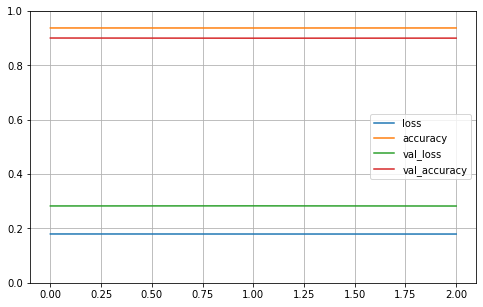

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [53]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 73.9103 - accuracy: 0.8358


[73.9102783203125, 0.8357999920845032]

## Making Predictions


In [58]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [63]:
import numpy as np

#model.predict_classes(X_new)
y_pred = np.argmax(model.predict(X_test[:3]), axis = -1)
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [13]:
import pandas as pd
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.224641,0.919091,0.299186,0.8900
1,0.221561,0.919236,0.302375,0.8926
2,0.217478,0.921382,0.303851,0.8944
